In [38]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

# sklearn utilities
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error as MSE 
from sklearn.preprocessing import robust_scale

# sklearn models
from sklearn import linear_model
from sklearn.svm import SVR

# Inputing Files

In [39]:
county_area = pd.read_csv('county_area.csv')
county_area = county_area.drop(["Areaname"], axis=1)
county_area = county_area.rename(columns={"STCOU": "fips"})
county_area

,fips,AREA
0,1001,604.49
1,1003,2027.08
2,1005,904.59
3,1007,625.50
4,1009,650.65
...,...,...
3123,56037,10491.73
3124,56039,4221.96
3125,56041,2087.66
3126,56043,2242.85


In [4]:
county_mask_use = pd.read_csv('mask_use.csv')
county_mask_use = county_mask_use.rename(columns={"COUNTYFP": "fips"})
county_mask_use

,fips,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
0,1001,0.053,0.074,0.134,0.295,0.444
1,1003,0.083,0.059,0.098,0.323,0.436
2,1005,0.067,0.121,0.120,0.201,0.491
3,1007,0.020,0.034,0.096,0.278,0.572
4,1009,0.053,0.114,0.180,0.194,0.459
...,...,...,...,...,...,...
3123,56037,0.061,0.295,0.230,0.146,0.268
3124,56039,0.095,0.157,0.160,0.247,0.340
3125,56041,0.098,0.278,0.154,0.207,0.264
3126,56043,0.204,0.155,0.069,0.285,0.287


In [5]:
county_cases = pd.read_csv('county_cases.csv')
county_cases = county_cases.drop(["county","state"], axis=1)
county_cases

,fips,cases,deaths
0,1001,2059,31
1,1003,6658,69
2,1005,1033,9
3,1007,840,14
4,1009,1932,25
...,...,...,...
3123,56037,462,2
3124,56039,747,1
3125,56041,431,3
3126,56043,144,7


In [6]:
county_pop = pd.read_csv('county_pop.csv', encoding='latin-1')
county_pop = county_pop.drop(['STNAME','CTYNAME'], axis=1)
county_pop = county_pop.rename(columns={"COUNTY": "fips"})
county_pop

,fips,POPESTIMATE2019
0,1001,55869
1,1003,223234
2,1005,24686
3,1007,22394
4,1009,57826
...,...,...
3123,56037,42343
3124,56039,23464
3125,56041,20226
3126,56043,7805


## Merging Dataframes Together

In [7]:
df = county_pop.merge(county_mask_use, how='left', on="fips")
df = df.merge(county_area, how="left", on="fips")
df['POP_DEN'] = df['POPESTIMATE2019'] / df['AREA']
df['POP_DENxALWAYS'] = df['POP_DEN'] * df['ALWAYS']
df['POP_DENxFREQUENTLY'] =df['POP_DEN'] * df['FREQUENTLY']
df['POP_DENxSOMETIMES'] = df['POP_DEN'] * df['SOMETIMES']
df['POP_DENxRARELY'] = df['POP_DEN'] * df['RARELY']
df['POP_DENxNEVER'] = df['POP_DEN'] * df['NEVER']
df['POPxALWAYS'] = df['POPESTIMATE2019'] * df['ALWAYS']
df['POPxFREQUENTLY'] =df['POPESTIMATE2019'] * df['FREQUENTLY']
df['POPxSOMETIMES'] = df['POPESTIMATE2019'] * df['SOMETIMES']
df['POPxRARELY'] = df['POPESTIMATE2019'] * df['RARELY']
df['POPxNEVER'] = df['POPESTIMATE2019'] * df['NEVER']
df

,fips,POPESTIMATE2019,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS,AREA,POP_DEN,POP_DENxALWAYS,POP_DENxFREQUENTLY,POP_DENxSOMETIMES,POP_DENxRARELY,POP_DENxNEVER,POPxALWAYS,POPxFREQUENTLY,POPxSOMETIMES,POPxRARELY,POPxNEVER
0,1001,55869,0.053,0.074,0.134,0.295,0.444,604.49,92.423365,41.035974,27.264893,12.384731,6.839329,4.898438,24805.836,16481.355,7486.446,4134.306,2961.057
1,1003,223234,0.083,0.059,0.098,0.323,0.436,2027.08,110.125895,48.014890,35.570664,10.792338,6.497428,9.140449,97330.024,72104.582,21876.932,13170.806,18528.422
2,1005,24686,0.067,0.121,0.120,0.201,0.491,904.59,27.289711,13.399248,5.485232,3.274765,3.302055,1.828411,12120.826,4961.886,2962.320,2987.006,1653.962
3,1007,22394,0.020,0.034,0.096,0.278,0.572,625.50,35.801759,20.478606,9.952889,3.436969,1.217260,0.716035,12809.368,6225.532,2149.824,761.396,447.880
4,1009,57826,0.053,0.114,0.180,0.194,0.459,650.65,88.874203,40.793259,17.241595,15.997356,10.131659,4.710333,26542.134,11218.244,10408.680,6592.164,3064.778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3123,56037,42343,0.061,0.295,0.230,0.146,0.268,10491.73,4.035845,1.081607,0.589233,0.928244,1.190574,0.246187,11347.924,6182.078,9738.890,12491.185,2582.923
3124,56039,23464,0.095,0.157,0.160,0.247,0.340,4221.96,5.557608,1.889587,1.372729,0.889217,0.872545,0.527973,7977.760,5795.608,3754.240,3683.848,2229.080
3125,56041,20226,0.098,0.278,0.154,0.207,0.264,2087.66,9.688359,2.557727,2.005490,1.492007,2.693364,0.949459,5339.664,4186.782,3114.804,5622.828,1982.148
3126,56043,7805,0.204,0.155,0.069,0.285,0.287,2242.85,3.479947,0.998745,0.991785,0.240116,0.539392,0.709909,2240.035,2224.425,538.545,1209.775,1592.220


## Normalize Data

In [8]:
def normalize(column):
    normal = []
    for value in column:
        value = (value - min(column)) / (max(column) - min(column))
        normal.append(value)
    return normal

In [9]:
def new_normal(dataframe):
    normal = robust_scale(dataframe)
    return normal

In [10]:
df = df.merge(county_cases, how="left", on="fips")
df.insert(0, 'Ones', 1)
column_titles = ["POPESTIMATE2019","NEVER","RARELY","SOMETIMES","FREQUENTLY","ALWAYS","AREA","POP_DEN","POP_DENxALWAYS","POP_DENxFREQUENTLY","POP_DENxSOMETIMES","POP_DENxRARELY","POP_DENxNEVER",'POPxALWAYS','POPxFREQUENTLY','POPxSOMETIMES','POPxRARELY','POPxNEVER']
new_df = df.reindex(columns=column_titles)
normal_all = new_normal(new_df)
normal_df = pd.DataFrame(normal_all)
normal_df.columns = column_titles
normal_df['fips'] = df['fips']
normal_df = normal_df.merge(county_cases, how="left", on="fips")
column_titles = ["fips","cases","deaths","POPESTIMATE2019","NEVER","RARELY","SOMETIMES","FREQUENTLY","ALWAYS","AREA","POP_DEN","POP_DENxALWAYS","POP_DENxFREQUENTLY","POP_DENxSOMETIMES","POP_DENxRARELY","POP_DENxNEVER",'POPxALWAYS','POPxFREQUENTLY','POPxSOMETIMES','POPxRARELY','POPxNEVER']
normal_df = normal_df.reindex(columns=column_titles)
normal_df

,fips,cases,deaths,POPESTIMATE2019,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS,AREA,...,POP_DENxALWAYS,POP_DENxFREQUENTLY,POP_DENxSOMETIMES,POP_DENxRARELY,POP_DENxNEVER,POPxALWAYS,POPxFREQUENTLY,POPxSOMETIMES,POPxRARELY,POPxNEVER
0,1001,2059,31,0.531522,-0.189873,0.013333,0.230769,1.096386,-0.241733,-0.087260,...,0.392066,0.986415,0.686119,0.574735,0.322373,0.388149,0.963127,0.700074,0.560736,0.323106
1,1003,6658,69,3.482726,0.189873,-0.186667,-0.230769,1.433735,-0.278221,2.556161,...,0.524723,1.416847,0.544150,0.524210,0.961035,2.663221,5.688549,2.873971,2.793491,4.353203
2,1005,1033,9,-0.018339,-0.012658,0.640000,0.051282,-0.036145,-0.027366,0.470378,...,-0.133261,-0.142277,-0.126075,0.052016,-0.139840,-0.009778,-0.015499,0.016638,0.277259,-0.015276
3,1007,840,14,-0.058754,-0.607595,-0.520000,-0.256410,0.891566,0.342075,-0.048220,...,0.001306,0.089251,-0.111614,-0.256064,-0.307315,0.011821,0.091853,-0.106102,-0.272649,-0.327508
4,1009,1932,25,0.566030,-0.189873,0.546667,0.820513,-0.120482,-0.173318,-0.001487,...,0.387452,0.466975,1.008201,1.061257,0.294052,0.442616,0.516004,1.141521,1.168028,0.349958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3123,56037,462,2,0.293013,-0.088608,2.960000,1.461538,-0.698795,-1.044470,18.284960,...,-0.367398,-0.396004,-0.335278,-0.260007,-0.378054,-0.034024,0.088161,1.040339,2.625569,0.225214
3124,56039,747,1,-0.039887,0.341772,1.120000,0.564103,0.518072,-0.716078,6.634632,...,-0.352040,-0.355401,-0.338757,-0.307004,-0.335629,-0.139745,0.055329,0.136269,0.449436,0.133611
3125,56041,431,3,-0.096983,0.379747,2.733333,0.487179,0.036145,-1.062714,2.668729,...,-0.339340,-0.322609,-0.285016,-0.037933,-0.272172,-0.222502,-0.081348,0.039673,0.928522,0.069685
3126,56043,144,7,-0.316007,1.721519,1.093333,-0.602564,0.975904,-0.957811,2.957099,...,-0.368973,-0.375142,-0.396628,-0.356235,-0.308237,-0.319737,-0.248058,-0.349510,-0.161863,-0.031260


In [11]:
normalize_pop = normalize(df['POPESTIMATE2019'])
normal_pop_df = pd.DataFrame(normalize_pop)
normal_pop_df

,0
0,0.005538
1,0.022210
2,0.002432
3,0.002204
4,0.005733
...,...
3123,0.004191
3124,0.002310
3125,0.001988
3126,0.000750


## Graphs

fig, ax = plt.subplots(figsize=(16,10))
for i in range(df.shape[0]):
    plt.scatter(df['POPESTIMATE2019'][i], df['cases'][i])
plt.xlabel('Population')
plt.ylabel('Positive Cases')
plt.ylim(0,60000)
plt.xlim(0,2000000)
plt.title('Population vs. Positive Cases')
plt.show()

fig, ax = plt.subplots(figsize=(16,10))
for i in range(df.shape[0]):
    plt.scatter(df['ALWAYS'][i], df['cases'][i])
plt.xlabel('Percentage of Mask Use')
plt.ylabel('Positive Cases')
plt.title('Percentage Mask Use vs. Positive Cases')
plt.show()

fig, ax = plt.subplots(figsize=(16,10))
for i in range(df.shape[0]):
    plt.scatter(df['ALWAYS'][i], df['NEVER'][i])
plt.xlabel('Percentage of Mask Use')
plt.ylabel('Percentage of NO Mask Use')
plt.title('Percentage Mask Use vs. Percent NO Mask Use')
plt.show()

fig, ax = plt.subplots(figsize=(16,10))
for i in range(df.shape[0]):
    plt.scatter(df['POP_DEN'][i], df['cases'][i])
plt.xlabel('Population density')
plt.ylabel('Cases')
plt.title('Population Density vs. Cases')
plt.show()

fig, ax = plt.subplots(figsize=(16,10))
for i in range(df.shape[0]):
    plt.scatter(df['POP_DEN'][i], df['deaths'][i])
plt.xlabel('Population Density')
plt.ylabel('Deaths')
plt.title('Population Density vs. Deaths')
plt.show()

fig, ax = plt.subplots(figsize=(16,10))
for i in range(df.shape[0]):
    plt.scatter(df['POP_DENxALWAYS'][i], df['cases'][i])
plt.xlabel('Population Density x Mask use')
plt.ylabel('Cases')
plt.title('Population Density x Mask use vs. Cases')
plt.show()

## Split Data

In [12]:
def split(X, Y, size):
    return train_test_split(X, Y, test_size=size)

# Models

## Linear Regression

In [13]:
x_train, x_test, y_train, y_test = split(normal_pop_df, df['cases'], 0.2)
x_train_lin = x_train.copy()
print(type(x_train_lin))
x_train_lin.insert(0, 'Ones', 1)
x = np.matrix(x_train_lin.values)
y = np.matrix(y_train.values)

<class 'pandas.core.frame.DataFrame'>


In [14]:
lin_regr = linear_model.LinearRegression(fit_intercept = False)
lin_regr.fit(x, y.T)
lin_regr.coef_ 

array([[  -342.20446884, 299305.96407817]])

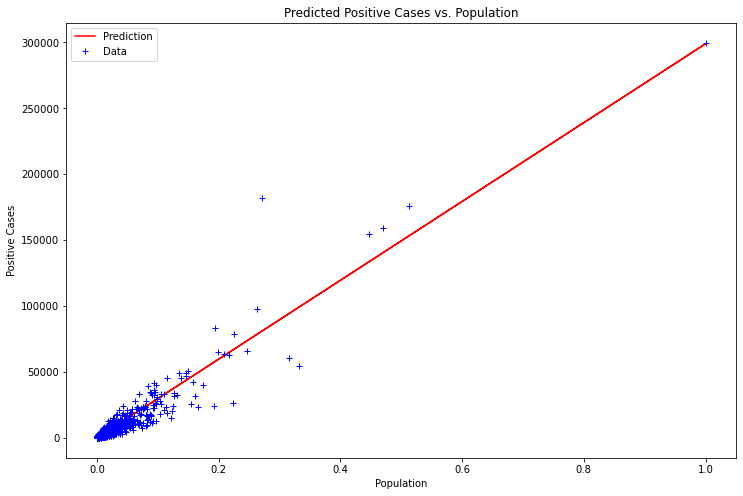

In [15]:
X = np.array(x[:, 1].A1)
f = lin_regr.predict(x).flatten()

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(X, f, color = "red", label='Prediction')
ax.plot(normal_pop_df[0], df['cases'], "r+",color = "blue", label='Data')
ax.legend(loc=2)
ax.set_xlabel('Population')
ax.set_ylabel('Positive Cases')
ax.set_title('Predicted Positive Cases vs. Population')
plt.show()

## SVM Regression

## Linear Regression using all of the given variables

In [68]:
def split(X, Y, size):
    return train_test_split(X, Y, test_size=size, random_state=0)

In [16]:
#Target Variable
y = np.log(df['cases']) 
x_train, x_test, y_train, y_test = train_test_split(normal_df,y, test_size = .2, shuffle = True)

In [17]:
all_var_reg = linear_model.LinearRegression(fit_intercept = False)
all_var_reg.fit(x_train,y_train)
y_predicted = all_var_reg.predict(x_test)
print('This model includes cases as a feature so there has to be overfitting')
print("The Mean Squared Error given normalized data:" , MSE(y_test, y_predicted))
print('Because the MSE is so small, this is an example of overfitting.')

This model includes cases as a feature so there has to be overfitting
The Mean Squared Error given normalized data: 1.3301945449342694
Because the MSE is so small, this is an example of overfitting.


## Linear Regression using mask use and population ONLY

In [18]:
y = np.log(df['cases']) 
x_train, x_test, y_train, y_test = train_test_split(normal_df[['POPESTIMATE2019','NEVER','RARELY','SOMETIMES','FREQUENTLY','ALWAYS']],y, test_size = .2, shuffle = True)

In [19]:
multi_var_reg = linear_model.LinearRegression(fit_intercept = False)
multi_var_reg.fit(x_train,y_train)
y_predicted = multi_var_reg.predict(x_test)

In [20]:
print("The Mean Squared Error given normalized data:" , MSE(y_test, y_predicted))
print("This very high MSE means that this particular variable configuration is not important")

The Mean Squared Error given normalized data: 1.9548435581102062
This very high MSE means that this particular variable configuration is not important


## Linear Regression using Population density and mask use

In [21]:
y = np.log(df['cases']) 
x_train, x_test, y_train, y_test = train_test_split(normal_df[['POP_DENxSOMETIMES','POP_DENxRARELY','POP_DENxALWAYS','POP_DENxFREQUENTLY','POP_DENxNEVER']],y, test_size = .2, shuffle = True)

In [22]:
multi_var_reg = linear_model.LinearRegression(fit_intercept = False)
multi_var_reg.fit(x_train,y_train)
y_predicted = multi_var_reg.predict(x_test)

In [23]:
print("The Mean Squared Error given normalized data:" , MSE(y_test, y_predicted))
print("THE MSE is still very high, continue to look for suitable features")

The Mean Squared Error given normalized data: 38.32696170049971
THE MSE is still very high, continue to look for suitable features


## Linear Regression using Area and POP x Mask use


In [24]:
y = np.log(df['cases']) 
x_train, x_test, y_train, y_test = train_test_split(normal_df[['AREA','POPxSOMETIMES','POPxRARELY','POPxALWAYS','POPxFREQUENTLY','POPxNEVER']],y, test_size = .2, shuffle = True)

In [25]:
multi_var_reg = linear_model.LinearRegression(fit_intercept = False)
multi_var_reg.fit(x_train,y_train)
y_predicted = multi_var_reg.predict(x_test)

In [26]:
print("The Mean Squared Error given normalized data:" , MSE(y_test, y_predicted))

The Mean Squared Error given normalized data: 33.68593610553851


## Linear Regression using Population and Population Density x Mask Use

In [27]:
y = np.log(df['cases']) 
x_train, x_test, y_train, y_test = train_test_split(normal_df[['POPESTIMATE2019','POP_DENxSOMETIMES','POP_DENxRARELY','POP_DENxALWAYS','POP_DENxFREQUENTLY','POP_DENxNEVER']],y, test_size = .2, shuffle = True)

In [28]:
multi_var_reg = linear_model.LinearRegression(fit_intercept = False)
multi_var_reg.fit(x_train,y_train)
y_predicted = multi_var_reg.predict(x_test)

In [29]:
print("The Mean Squared Error given normalized data:" , MSE(y_test, y_predicted))

The Mean Squared Error given normalized data: 38.401388578946595


## Tester

In [124]:
y = np.log(df['cases']) 
x_train, x_test, y_train, y_test = split(normal_df[['POPESTIMATE2019','POP_DEN','NEVER','RARELY','SOMETIMES','FREQUENTLY','ALWAYS']],y, size = .2)

In [125]:
multi_var_reg = linear_model.LinearRegression(normalize = True, fit_intercept = True)
multi_var_reg.fit(x_train,y_train)
y_predicted = multi_var_reg.predict(x_test)

In [126]:
print("The Mean Squared Error given normalized data:" , MSE(y_test, y_predicted))
multi_var_reg.score(x_test,y_test)

The Mean Squared Error given normalized data: 1.8300038458859706


0.27916594413717977

## Linear Regression using Population x Mask Use and Population Desnsity x Mask use

In [35]:
y = np.log(df['cases']) 
x_train, x_test, y_train, y_test = train_test_split(normal_df[['POPESTIMATE2019','AREA','POPESTIMATE2019','POP_DENxSOMETIMES','POP_DENxRARELY','POP_DENxALWAYS','POP_DENxFREQUENTLY','POP_DENxNEVER','POPxSOMETIMES']],y, test_size = .2 shuffle = True)

SyntaxError: invalid syntax (<ipython-input-35-a36e62976cd3>, line 2)

In [ ]:
y = np.log(df['cases']) 
sizes = [.05,.1,.15,.2,.25,.3,.35,.4]
outs = []
for size in sizes:
    avg = []
    for i in range(20):
        x_train, x_test, y_train, y_test = train_test_split(normal_df[['POPESTIMATE2019','POP_DENxSOMETIMES','POP_DENxRARELY','POP_DENxALWAYS','POP_DENxFREQUENTLY','POP_DENxNEVER','POPxSOMETIMES','POPxRARELY','POPxALWAYS','POPxFREQUENTLY','POPxNEVER',]],y, test_size = size, shuffle = True)
        multi_var_reg = linear_model.LinearRegression(fit_intercept = False)
        multi_var_reg.fit(x_train,y_train)
        y_predicted = multi_var_reg.predict(x_test)
        avg.append(MSE(y_test, y_predicted))
    outs.append(sum(avg) / len(avg))
train_splits = sizes[outs.index(min(outs))]
print('The best Split: ', train_split)
print('With an avg MSE of: ', min(outs))

In [ ]:
print("The Mean Squared Error given normalized data:" , MSE(y_test, y_predicted))

## Optimized Linear Regression

In [42]:
def split(X, Y, size):
    return train_test_split(X, Y, test_size=size, random_state=0)

In [66]:
y = np.log(df['cases']) 
x_train, x_test, y_train, y_test = split(normal_df[['POPESTIMATE2019','POP_DEN','NEVER','RARELY','SOMETIMES','FREQUENTLY','ALWAYS']],y, size = size)
multi_var_reg = linear_model.LinearRegression(normalize = True, fit_intercept = True)

multi_var_reg.fit(x_train,y_train)
y_predicted = multi_var_reg.predict(x_test)

print('MSE of: ', MSE(y_test, y_predicted))

MSE of:  1.6537120614085443


In [67]:
multi_var_reg.score(x_test,y_test)

0.2884393736111551

In [61]:
multi_var_reg.get_params()

{'copy_X': True, 'fit_intercept': False, 'n_jobs': None, 'normalize': False}

## SVM

In [136]:
x_train, x_test, y_train, y_test = split(normal_df[['POPESTIMATE2019','POP_DEN','NEVER','RARELY','SOMETIMES','FREQUENTLY','ALWAYS']],np.log(df['cases']), .2)

In [141]:
kernels = ['rbf', 'linear', 'poly']
outs = []
for k in kernels:
    svr = SVR(kernel=k)
    svr.fit(x_train, y_train)
    svr_predict = svr.predict(x_test)
    outs.append(MSE(y_test, svr_predict))
optimal_kernel = kernels[outs.index(min(outs))]
print('Best kernel is:', optimal_kernel)
print('With average MSE of:', min(outs))

Best kernel is: rbf
With average MSE of: 0.8178628724760727


In [143]:
regs = [1,2,5,200]
outs = []
for reg in regs:
    svr = SVR(kernel=optimal_kernel, C=reg)
    svr.fit(x_train, y_train)
    svr_predict = svr.predict(x_test)
    outs.append(MSE(y_test, svr_predict))
optimal_C = regs[outs.index(min(outs))]
print('Best C value is:', optimal_C)
print('With average MSE of:', min(outs))


Best C value is: 200
With average MSE of: 0.6566630110429951


In [ ]:
svr = SVR(kernel=optimal_kernel, C=1)
svr.fit(x_train, y_train)
y_train_pred = svr.predict(x_train)
y_test_pred = svr.predict(x_test)
plt.plot(y_train, y_train_pred,'*r')
plt.plot(y_test, y_test_pred, '*g')
plt.show()

print(MSE(y_test, svr.predict(x_test)))